In [1]:
import warnings

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import numpy as np
import scipy
from evaluation import (
    energy_distance,
    eval_progressive_logreg,
    test_accuracy,
)
from get_model import get_model_and_data
from main import run_simple_lmc_numpyro


%env JAX_PLATFORM_NAME=cuda
warnings.simplefilter("ignore", FutureWarning)

jnp.set_printoptions(precision=3, suppress=True)
jax.config.update("jax_enable_x64", True)
print(jax.devices("cuda"))

dataset = scipy.io.loadmat("mcmc_data/benchmarks.mat")
data_name = "banana"
model_logreg, data_split = get_model_and_data(dataset, data_name)
x_train, labels_train, x_test, labels_test = data_split

env: JAX_PLATFORM_NAME=cuda
[CudaDevice(id=0)]
Data shape: (5300, 2)


In [2]:
file_name = f"mcmc_data/{data_name}_ground_truth.npy"

# gt_nuts = MCMC(
#     NUTS(model_logreg, step_size=1.0),
#     num_warmup=2**10,
#     num_samples=2**13,
#     num_chains=2**3,
#     chain_method="vectorized",
# )
# gt_nuts.run(jr.PRNGKey(0), x_train, labels_train)
# gt_logreg = vec_dict_to_array(gt_nuts.get_samples())
# np.save(file_name, gt_logreg)

gt_logreg = np.load(file_name)
print(f"Ground truth shape: {gt_logreg.shape}")
size_gt_half = int(gt_logreg.shape[0] // 2)
energy_bias = energy_distance(gt_logreg[:size_gt_half], gt_logreg[size_gt_half:])
print(f"Energy bias: {energy_bias}")
print(f"test accuracy: {test_accuracy(x_test, labels_test, gt_logreg)}")
flattened_gt = jnp.reshape(gt_logreg, (-1, gt_logreg.shape[-1]))
print(flattened_gt.shape)
print(jnp.var(flattened_gt, axis=0))
print(jnp.mean(flattened_gt, axis=0))

Ground truth shape: (65536, 3)
Energy bias: 6.921607180354616e-06
test accuracy: (Array(0.536, dtype=float32), Array(0.544, dtype=float32))
(65536, 3)
[0.001 0.004 0.004]
[-0.128 -0.051 -0.082]


In [3]:
num_particles = 2**15

In [10]:
out_lmc, steps_lmc = run_simple_lmc_numpyro(
    jr.key(0),
    model_logreg,
    (x_train, labels_train),
    num_particles,
    chain_len=2**5,
    chain_sep=1.0,
    tol=0.01,
)
print(jtu.tree_map(lambda x: x.shape, out_lmc))

100.00%|██████████| [01:28<00:00,  1.14%/s]

{'W': (32768, 32, 2), 'b': (32768, 32, 1)}


/tmp/ipykernel_92239/1578896225.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


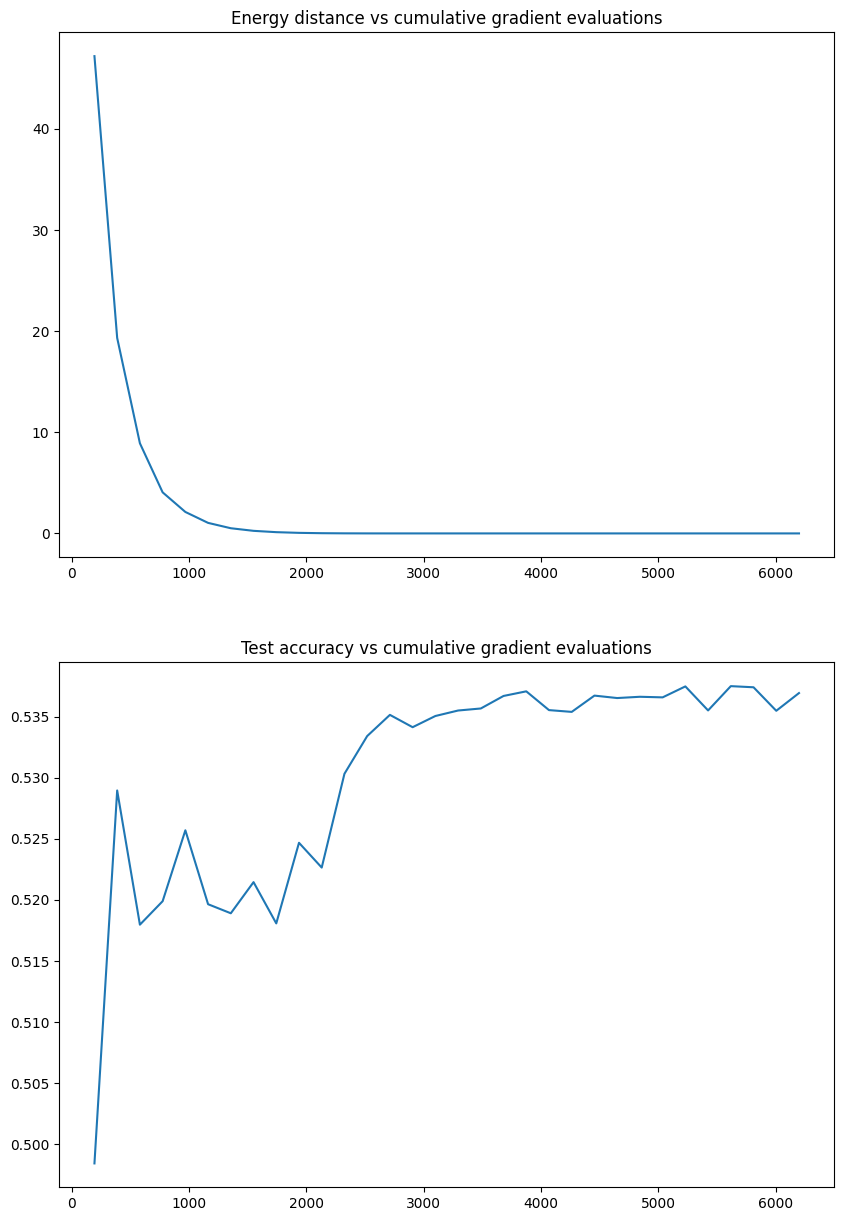

In [11]:
fig, result_dict = eval_progressive_logreg(
    out_lmc, gt_logreg, steps_lmc, 0, x_test, labels_test
)
fig.show()

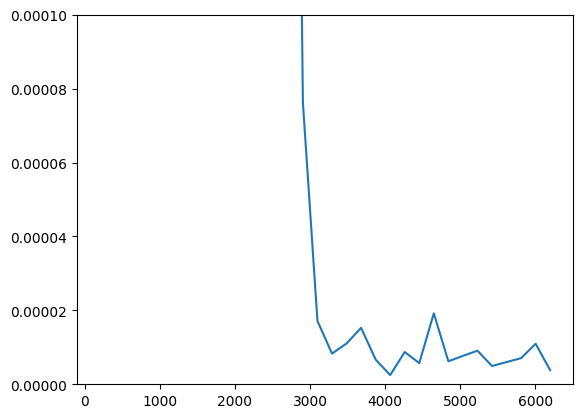

In [15]:
from matplotlib import pyplot as plt


plt.plot(result_dict["cumulative_evals"], result_dict["energy_err"])
plt.ylim(0, 0.0001)
plt.show()